In [3]:
# Importing the libraries
import numpy as np
import pandas as pd
import re
import pickle 
import nltk
#import heapq
from sklearn.datasets import load_files
import csv
import matplotlib.pyplot as plt
import itertools
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from sklearn import metrics
stop_words = set(stopwords.words('english')) 
import io, codecs

In [4]:
Data = pd.read_excel('NewsData.xlsx')

X=Data.iloc[:,0].values
y=Data.iloc[:,1].values

corpus_sent = []
for i in range(0,len(X)):
    text = re.sub(r'\W',' ',str(X[i]))
    text = re.sub("@[\w\d]+", "", text)           #delete any references to other people
    text = re.sub("http:[\w\:\/\.]+","", text)    #replace url's
    text = re.sub('[^[A-Za-z]\s]','', text)      #replace non alphabets and non spaces
    text=  re.sub('[^a-zA-Z]',' ', text)         #remoce non words (special characters)
    text = re.sub('[^\w\s]','', text)            #remove white spaces
    text = text.lower()
    words = nltk.tokenize.word_tokenize(text)
    tokens =' '.join([word for word in words if not text in stop_words])
    corpus_sent.append(tokens)
    

lem = WordNetLemmatizer()

# word tokenization
for i in range(len(corpus_sent)):
    words = nltk.word_tokenize(corpus_sent[i])
    stm_word = [lem.lemmatize(word) for word in words]
    corpus_sent[i] = ' '.join(stm_word)

In [5]:
#code for fastext wordembedding
w2vModel ={}
f = codecs.open('glove.840B.300d.txt', encoding='utf-8')
for line in f:
  values = line.rstrip().rsplit(' ')
  word = values[0]
  coef = np.asarray(values[1:], dtype='float32')
  w2vModel[word] =coef
f.close()


In [6]:
docs_vectors = pd.DataFrame()
stopwords = nltk.corpus.stopwords.words('english')   ## !! added later

## in below... all lowercase shall help in covering all the words, instead of adding ""A-Z"" in RegEx which may not provide suitable outputs
for doc in corpus_sent:
    temp = pd.DataFrame()   ## initially empty, and empty on every iteration
    for word in doc.split(' '):  ## !!
        if word not in stopwords: 
            try:
                word_vec = w2vModel[word]  ## if present, the following code applies
                temp = temp.append(pd.Series(word_vec), ignore_index = True)  ## .Series to make it easier to append "without" index labels
            except:
                pass
    doc_vector = temp.mean()
    docs_vectors = docs_vectors.append(doc_vector, ignore_index = True) ## added to the empty data frame
#docs_vectors.shape 

In [8]:
docs_vectors.shape 

(3000, 300)

In [9]:
docs_vectors['sentiment'] = Data['Sentiment']
docs_vectors = docs_vectors.dropna()

from sklearn.model_selection import train_test_split ## here vectorization (vectorizer) again shall not come, since we are calculated weights 
from sklearn.ensemble import AdaBoostClassifier

train_x, test_x, train_y, test_y = train_test_split(docs_vectors.drop('sentiment', axis = 1),
                                                   docs_vectors['sentiment'],
                                                   test_size = 0.2,
                                                   random_state = 1)

In [10]:
model = AdaBoostClassifier(n_estimators = 800, random_state = 1)
model.fit(train_x, train_y)
ada_pred = model.predict(test_x)

In [14]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
ada_accuracy = accuracy_score(test_y,ada_pred)
ada_f1 = f1_score(test_y,ada_pred)
ada_precision = precision_score(test_y,ada_pred)
ada_recall = recall_score(test_y,ada_pred)
print(ada_accuracy*100)
print(ada_f1*100)
print(ada_precision*100)
print(ada_recall*100)

92.83333333333333
95.24861878453038
94.72527472527472
95.77777777777777


In [13]:
#from sklearn.metrics import classification_report

#print(classification_report(test_y, ada_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.84      0.85       150
         1.0       0.95      0.96      0.95       450

    accuracy                           0.93       600
   macro avg       0.91      0.90      0.90       600
weighted avg       0.93      0.93      0.93       600



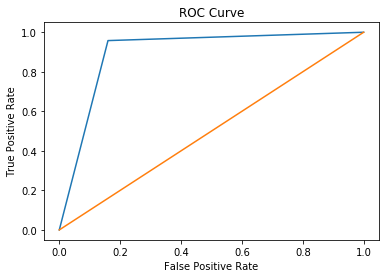

<Figure size 432x288 with 0 Axes>

In [15]:

'''fpr_ada, tpr_ada, thresholds = roc_curve(test_y, ada_pred)
plt.plot(fpr, tpr, label='ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# save figure
plt.savefig('roc_curve_svm.png', dpi=200)'''

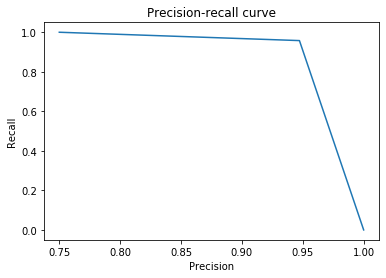

<Figure size 432x288 with 0 Axes>

In [17]:
'''from sklearn.metrics import precision_recall_curve 

precision, recall, thresholds = precision_recall_curve(test_y, test_pred)
# create plot
plt.plot(precision, recall, label='Precision-recall curve')
plt.xlabel('Precision')
plt.ylabel('Recall')
plt.title('Precision-recall curve')
plt.show()

# save figure
plt.savefig('precision_recall.png', dpi=200)'''

In [15]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()
clf = clf.fit(train_x, train_y)

rf_pred = clf.predict(test_x)

c:\users\khair\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [16]:
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
rf_accuracy = accuracy_score(test_y,rf_pred)
rf_f1 = f1_score(test_y,rf_pred)
rf_precision = precision_score(test_y,rf_pred)
rf_recall = recall_score(test_y,rf_pred)
print(rf_accuracy*100)
print(rf_f1*100)
print(rf_precision*100)
print(rf_recall*100)

93.0
95.40481400437638
93.96551724137932
96.88888888888889


In [20]:
#print(classification_report(test_y, rf_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.84      0.85       150
         1.0       0.95      0.96      0.95       450

    accuracy                           0.93       600
   macro avg       0.91      0.90      0.90       600
weighted avg       0.93      0.93      0.93       600



In [17]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
#roc curve ada
fpr_ada, tpr_ada,thresholds_ada = roc_curve(test_y, ada_pred)
#rf roc curve
fpr_rf, tpr_rf, thresholds_rf = roc_curve(test_y, rf_pred)

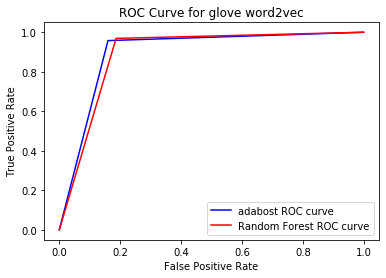

In [20]:
# create plot
plt.plot(fpr_ada, tpr_ada, label='adabost ROC curve', c = 'b')
plt.plot(fpr_rf, tpr_rf, label='Random Forest ROC curve', c = 'r')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for glove word2vec')
plt.legend(loc="lower right")

In [22]:
#precision recall curve ada
fpr_ada, tpr_ada,thresholds_ada = precision_recall_curve(test_y, ada_pred)
#rf precision recall curve
fpr_rf, tpr_rf, thresholds_rf = precision_recall_curve(test_y, rf_pred)

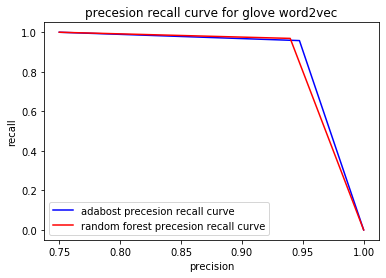

In [23]:
plt.plot(fpr_ada, tpr_ada, label='adabost precesion recall curve', c = 'b')
plt.plot(fpr_rf, tpr_rf, label='random forest precesion recall curve', c = 'r')
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('precesion recall curve for glove word2vec')
plt.legend(loc="lower left")